In [46]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import io
import base64
import tempfile
from IPython.display import HTML
from numpy import loadtxt

from controller_utils import CartpoleDx, sample_initial_signal, Clamp, episode_loss
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost
import mpc.util as eutil
from controllers import DDeePC

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
class WeightClipper(object):

    def __init__(self, frequency=1):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        # if hasattr(module, 'weight'):
        for param in module.parameters():
            w = param.data
            w = w.clamp(10e-3,10e4)
            param.data = w
clipper = WeightClipper()

## Data Collection


In [48]:
Tini = 4
m = 1
p = 4
Tf = 20
T = (m+1)*(Tini + Tf + p) + 14
n_batch = 1
device = 'cuda' if torch.cuda.is_available() else 'mps'
device = 'cpu'
print(device)
ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise = np.diag(np.kron(np.ones(T), np.array([0.01, 0.01, 0.005, 0.01]))) @ np.random.randn(*yd.shape)
yd = yd + noise
dx = CartpoleDx().to(device)
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

cpu


In [49]:
u_constraints = np.ones(Tf)*dx.upper
y_constraints = np.kron(np.ones(Tf), np.array([0.25, 0.5, 0.1, 0.5]))
r = torch.ones(m)*0.01
q = torch.ones(p)*100
lam_g1 = torch.Tensor([513.409]).to(device)
lam_g2 = torch.Tensor([0.315]).to(device)
lam_y = torch.Tensor([541.258]).to(device)

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic=True, q=q, r=r, lam_g1=lam_g1, lam_g2=lam_g2, lam_y=lam_y
).to(device)

In [50]:
for param in controller.parameters():
    print(param)

In [51]:
episodes = 100
ref = torch.zeros(size=(n_batch,p))
perfect = torch.kron(torch.ones(episodes+Tini), ref).to(device)
ref = torch.kron(torch.ones(Tf), ref).to(device)
n_row = np.sqrt(n_batch).astype(np.uint8)
n_col = n_row
# opt = torch.optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-3,100))

epochs = 1
pbar = tqdm(range(epochs))
cum_loss = []
done = False
I, PI = controller.get_PI()
PI = torch.Tensor(I-PI).to(device)

for j in pbar:

    uini = torch.zeros(size=(n_batch, Tini*m)).to(device)
    zero = torch.zeros(n_batch)
    th = uniform((n_batch), -0.01, 0.01)
    yini = torch.stack((zero, zero, th, zero), dim=1).repeat(1,Tini).to(device)
    traj = yini
    G, E, Y, U = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    t_dir = tempfile.mkdtemp()
    for i in range(episodes):
        
        noise = torch.diag(torch.kron(torch.ones(Tini), torch.Tensor([0.01, 0.01, 0.005, 0.01])))@torch.randn(p*Tini,)
        noise = noise.repeat(n_batch, 1).to(device)

        g, u_pred, y_pred, sig_y = controller(ref=ref, y_ini=yini+noise, u_ini=uini)
        G, E = torch.cat((G, g.unsqueeze(1)), axis=1), torch.cat((E, sig_y.unsqueeze(1)), axis=1) 
        input = u_pred[:,:m]
        U = torch.cat((U, input.unsqueeze(1)), axis=1)
        y = dx(yini[:,-p:], input)
        Y = torch.cat((Y, y.unsqueeze(1)), axis=1)
        yini = torch.cat((yini[:, p:], y), axis=1)
        fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col,3*n_row), gridspec_kw = {'wspace':0, 'hspace':0})
        # axs = axs.reshape(-1)
        for i in range(n_batch):
            dx.get_frame(y[i], ax=axs)
            axs.get_xaxis().set_visible(True)
            axs.get_yaxis().set_visible(True)
        fig.tight_layout()
        fig.savefig(os.path.join(t_dir, 'frame_{:03d}.png'.format(i)))
        plt.close(fig)
#     loss = episode_loss(G=G, U=U, Y=Y, E=E, controller=controller, PI=PI)
#     cum_loss.append(loss.item())
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     controller.apply(clipper)
#     pbar.set_description(f'l={loss.item():.3f}, ly={controller.lam_y.data.item():.3f},\
#  lg1={controller.lam_g1.data.item():.3f}, lg2={controller.lam_g2.data.item():.3f}, q = {controller.q.data}, r = {controller.r.data}')

100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


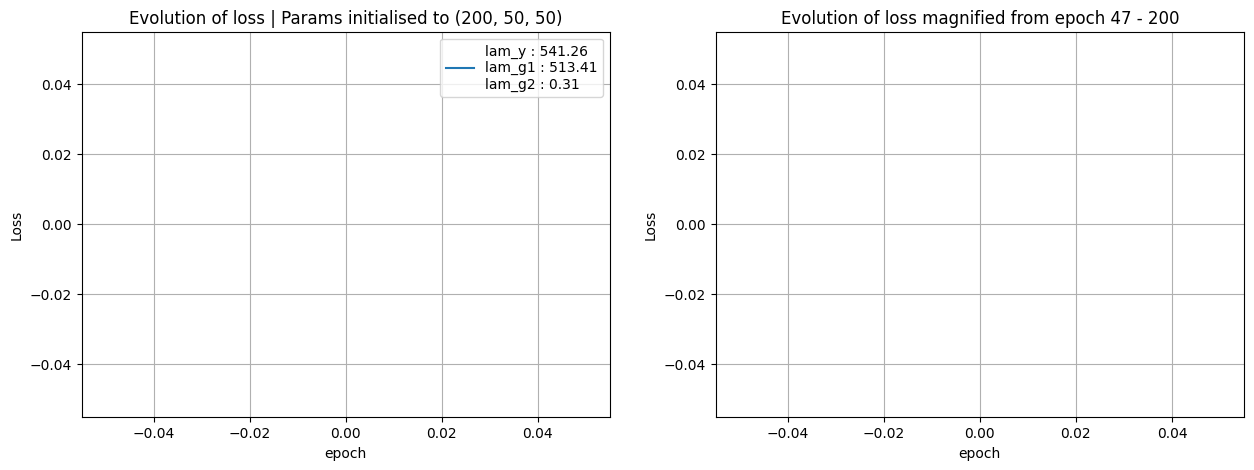

In [52]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,2,1)
plt.title('Evolution of loss | Params initialised to (200, 50, 50)')
plt.plot(range(len(cum_loss)), cum_loss, label=f'lam_y : {controller.lam_y.data.item():.2f}\nlam_g1 : {controller.lam_g1.data.item():.2f}\nlam_g2 : {controller.lam_g2.data.item():.2f}')
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.legend()
plt.subplot(1,2,2)
plt.title('Evolution of loss magnified from epoch 47 - 200')
plt.plot(range(len(cum_loss[37:])), cum_loss[37:])
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.show()

In [53]:
for param in controller.parameters():
    print(param)

In [56]:
vid_fname = 'cartpole.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)
os.system(cmd)
# print('Saving video to: {}'.format(vid_fname))

video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

FileNotFoundError: [Errno 2] No such file or directory: 'cartpole.mp4'